<a href="https://colab.research.google.com/github/AnapuramAbhilashGoud/NLP-Assignments/blob/main/NLP_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/10 | Loss: 0.6795 | Acc: 0.6200
Epoch 2/10 | Loss: 0.4120 | Acc: 0.8600
Epoch 3/10 | Loss: 0.0124 | Acc: 1.0000
Epoch 4/10 | Loss: 0.0017 | Acc: 1.0000
Epoch 5/10 | Loss: 0.0011 | Acc: 1.0000
Epoch 6/10 | Loss: 0.0008 | Acc: 1.0000
Epoch 7/10 | Loss: 0.0006 | Acc: 1.0000
Epoch 8/10 | Loss: 0.0005 | Acc: 1.0000
Epoch 9/10 | Loss: 0.0004 | Acc: 1.0000
Epoch 10/10 | Loss: 0.0004 | Acc: 1.0000


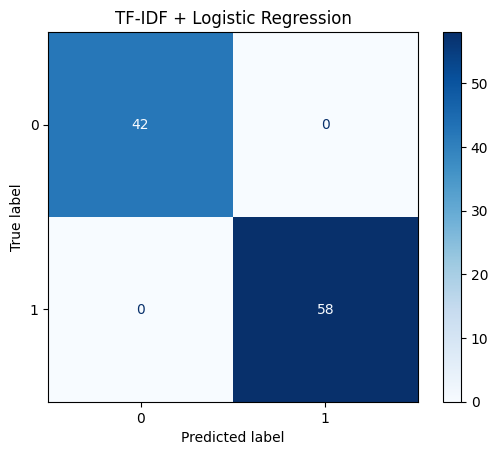

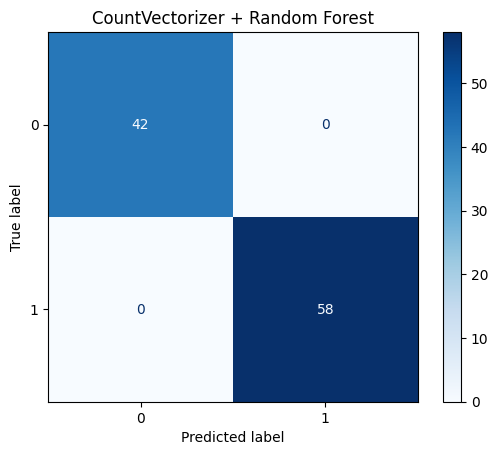

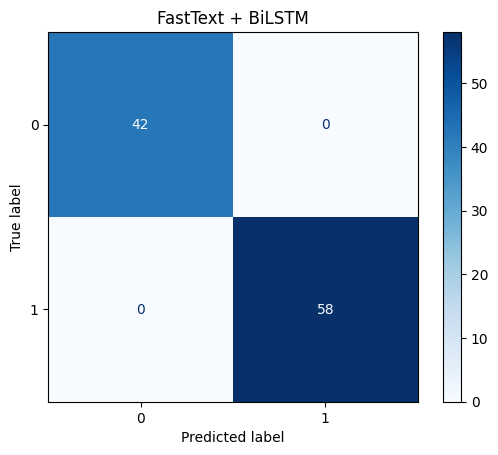

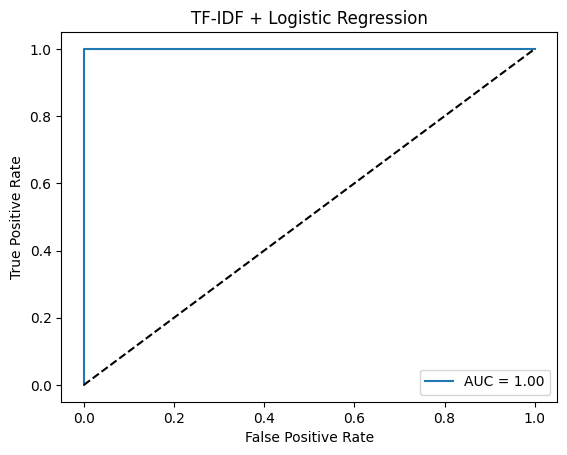

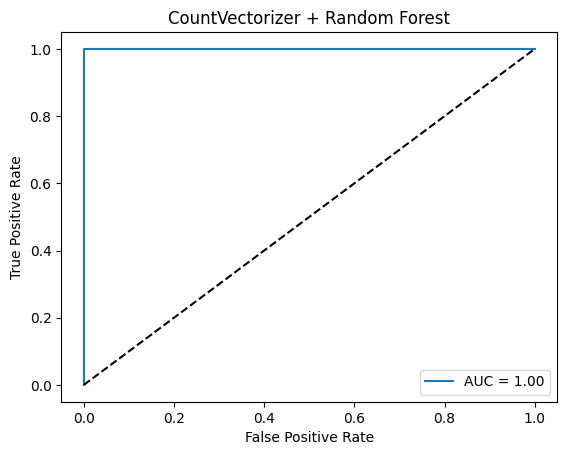

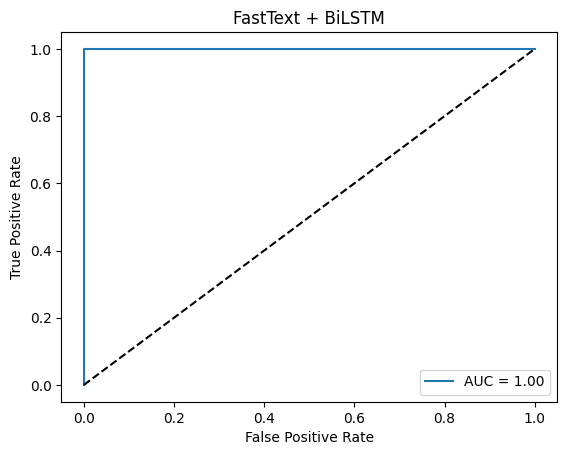

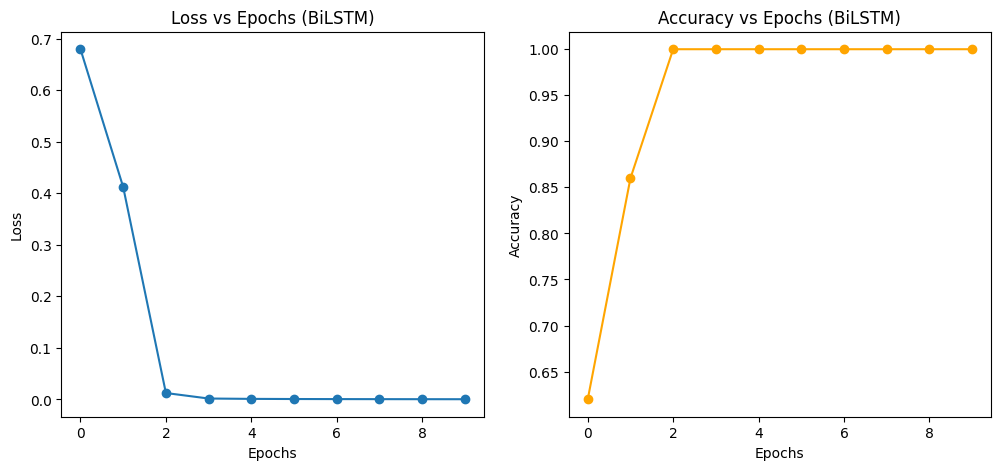

In [1]:
# ===========================================
# Brain Stroke Prediction - NLP Approach
# ===========================================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# -----------------------------
# 1️⃣ Create a sample dataset
# -----------------------------
np.random.seed(42)

# Simulate some patient notes
notes = [
    "high blood pressure and headache",
    "normal blood pressure and healthy",
    "diabetes and high cholesterol",
    "family history of stroke",
    "fever and cold",
    "tiredness and dizziness",
    "healthy lifestyle and exercise",
    "blood pressure normal and fit",
    "migraine and blurred vision",
    "smoking and alcohol consumption"
]

labels = [1, 0, 1, 1, 0, 1, 0, 0, 1, 1]  # 1 = Stroke, 0 = No Stroke

# Expand dataset
notes = notes * 50
labels = labels * 50

df = pd.DataFrame({"text": notes, "label": labels})
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], test_size=0.2, random_state=42)

# -----------------------------
# 2️⃣ Model 1: TF-IDF + Logistic Regression
# -----------------------------
tfidf = TfidfVectorizer(max_features=100)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

lr_model = LogisticRegression()
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)
y_prob_lr = lr_model.predict_proba(X_test_tfidf)[:,1]

# -----------------------------
# 3️⃣ Model 2: CountVectorizer + Random Forest
# -----------------------------
count_vect = CountVectorizer(max_features=100)
X_train_count = count_vect.fit_transform(X_train)
X_test_count = count_vect.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_count, y_train)
y_pred_rf = rf_model.predict(X_test_count)
y_prob_rf = rf_model.predict_proba(X_test_count)[:,1]

# -----------------------------
# 4️⃣ Model 3: FastText + BiLSTM (PyTorch)
# -----------------------------
# Simple tokenization and dataset
token2idx = {"<PAD>":0, "<UNK>":1}
for text in df["text"]:
    for word in text.split():
        if word not in token2idx:
            token2idx[word] = len(token2idx)

max_len = 10

def encode(text):
    tokens = text.split()
    ids = [token2idx.get(t, 1) for t in tokens]
    if len(ids) < max_len:
        ids = ids + [0]*(max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids

X_train_seq = np.array([encode(t) for t in X_train])
X_test_seq = np.array([encode(t) for t in X_test])

class StrokeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.FloatTensor(y.values)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StrokeDataset(X_train_seq, y_train)
test_dataset = StrokeDataset(X_test_seq, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=16, hidden_dim=32):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

vocab_size = len(token2idx)
model = BiLSTMModel(vocab_size)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# -----------------------------
# 5️⃣ Training BiLSTM
# -----------------------------
epochs = 10
train_losses = []
train_accs = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    train_losses.append(epoch_loss/len(train_loader))
    train_accs.append(correct/total)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {train_losses[-1]:.4f} | Acc: {train_accs[-1]:.4f}")

# -----------------------------
# 6️⃣ Evaluate BiLSTM
# -----------------------------
model.eval()
y_pred_bilstm = []
y_prob_bilstm = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze()
        y_prob_bilstm.extend(outputs.tolist())
        y_pred_bilstm.extend((outputs>0.5).float().tolist())

# -----------------------------
# 7️⃣ Confusion Matrix
# -----------------------------
def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

plot_confusion(y_test, y_pred_lr, "TF-IDF + Logistic Regression")
plot_confusion(y_test, y_pred_rf, "CountVectorizer + Random Forest")
plot_confusion(y_test, y_pred_bilstm, "FastText + BiLSTM")

# -----------------------------
# 8️⃣ ROC Curves
# -----------------------------
def plot_roc(y_true, y_prob, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_roc(y_test, y_prob_lr, "TF-IDF + Logistic Regression")
plot_roc(y_test, y_prob_rf, "CountVectorizer + Random Forest")
plot_roc(y_test, y_prob_bilstm, "FastText + BiLSTM")

# -----------------------------
# 9️⃣ Loss vs Epochs & Accuracy vs Epochs for BiLSTM
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, marker='o')
plt.title("Loss vs Epochs (BiLSTM)")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(train_accs, marker='o', color='orange')
plt.title("Accuracy vs Epochs (BiLSTM)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.show()
